In [1]:
import math
import scipy
import numpy as np
import pandas as pd
import math as m
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

from scipy.spatial import distance_matrix
from scipy import linalg
from scipy.optimize import minimize
from scipy.linalg import eig, eigh
from scipy.fft import fft
from scipy.special import eval_gegenbauer, sph_harm

from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from sklearn.decomposition import KernelPCA, PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors

#import scaleogram as scg
import matplotlib.pyplot as plt
import warnings

from tqdm import tqdm

from visuals import *
from my_lib import *
from SSA_lib import SSA

In [2]:
warnings.simplefilter('ignore')

# plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

In [3]:
def CartesianToSpherical(point):
    r = np.sqrt(sum(point ** 2))
    n = len(point)
    phi = np.zeros(n - 1)
    
    for i in range(n - 2):
        phi[i] = np.arccos(point[i] / np.sqrt(sum(point[i:] ** 2)))
        
    if point[-1] >= 0:
        phi[n - 2] = np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
    else:
        phi[n - 2] = 2 * np.pi - np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
        
    return np.hstack((phi, r))


def TrajectoryToSpherical(tr):
    tr_spherical = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_spherical[i] = CartesianToSpherical(point)
    return tr_spherical


def SphericalToCartesian(point):
    phi, r = point[:-1], point[-1]
    n = len(point)
    x = np.zeros(n) 
    cur = r
    
    for i in range(n - 1):
        x[i] = cur * np.cos(phi[i])
        cur *= np.sin(phi[i])

    x[n - 1] = cur
    return x
    
def TrajectoryToCartesian(tr):
    tr_cartesian = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_cartesian[i] = SphericalToCartesian(point)
    return tr_cartesian

def HankelMatrix(X, L):  
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

In [4]:
dt = 450 * 10
data = pd.read_csv('data/long_walk_100_acc.csv', delimiter =';', decimal=',')[7101:7101+dt]

frequency = len(data)/(data['time'].values[-1]-data['time'].values[0])

assert 490 < frequency < 510, f'Bad frequency {frequency}'
print(f'Frequency {frequency}')

x_acc = ( (data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
_m = np.mean(x_acc)
_std = (sum((x_acc - _m)**2)/len(x_acc))**.5

x_acc = (x_acc-_m)

t = (data['time'].values).astype(float).reshape([-1,])
t = np.linspace(0,t[-1]-t[0],len(x_acc))

fig = go.Figure()
fig.add_scatter(y = x_acc, mode='lines', name='Sum squares')
fig.show()

Frequency 500.055561729081


In [470]:
def rot_matrix(n, a, b, alpha):
    assert a < b
    M = np.diag(np.ones(n))
    M[a,a] = np.cos(np.deg2rad(alpha))
    M[a,b] = np.sin(np.deg2rad(alpha))
    M[b,a] = np.sin(np.deg2rad(alpha)) * (-1)
    M[b,b] = np.cos(np.deg2rad(alpha))
    return M

In [540]:
X = HankelMatrix(x_acc,500)

pca_ = KernelPCA(n_components = 12, kernel = 'rbf')
X_PCA = pca_.fit_transform(X)

from sklearn.manifold import LocallyLinearEmbedding
n_components = 15
embedding = LocallyLinearEmbedding(n_components = n_components,
                                   method = 'hessian',
                                   n_neighbors = int(1+n_components * (n_components + 3) / 2)) 

X_PCA = embedding.fit_transform(X)


X_PCA_ROT = X_PCA#@rot_matrix(4,1,3,0)

fig_2 = go.Figure()
fig_2.update_layout(autosize=False, width=1000, height=1000)

fig_2.add_trace(go.Scatter3d(x=X_PCA_ROT[:,0],
                             y=X_PCA_ROT[:,1],
                             z=X_PCA_ROT[:,2],
                             mode='lines'
                            )
                )


fig_2.layout.template = 'plotly_white'
fig_2.show()

In [541]:
X_sp = TrajectoryToSpherical(X_PCA_ROT)

In [542]:
fig_2 = go.Figure()
fig_2.update_layout(autosize = False, width = 1000, height = 1000)

fig_2.add_trace(go.Scatter3d(x = X_sp[:, 0],
                             y = X_sp[:, 1],
                             z = X_sp[:, 2],
                             mode='lines'
                            )
                )


fig_2.layout.template = 'plotly_white'
fig_2.show()

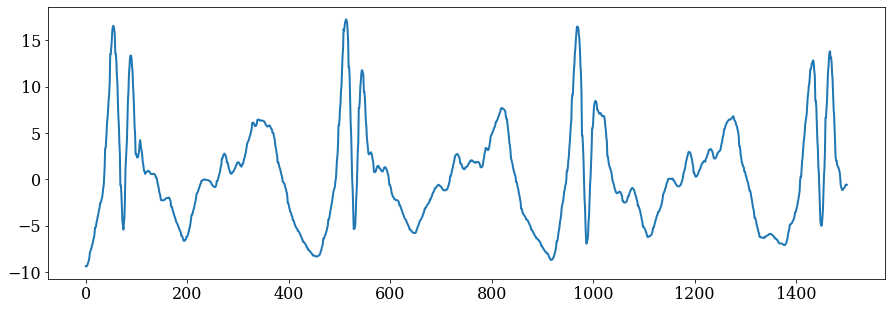

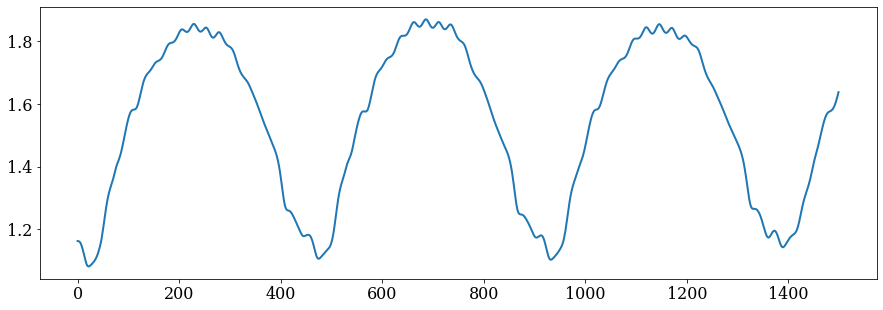

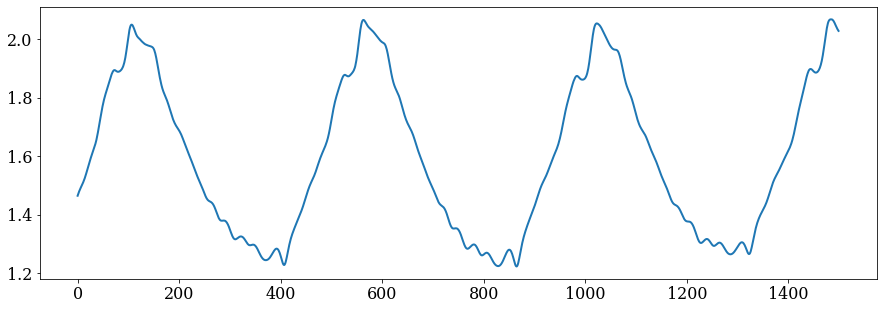

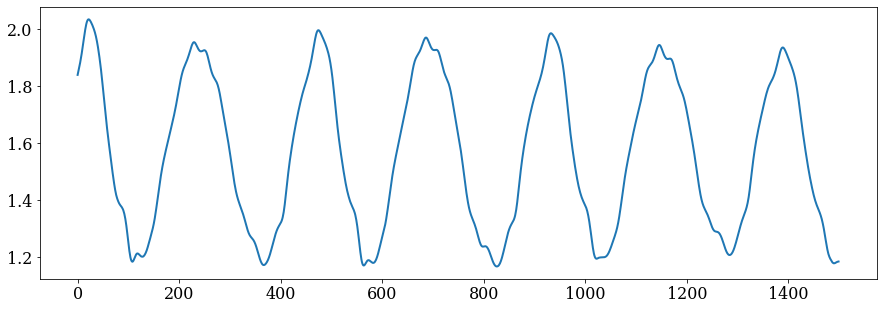

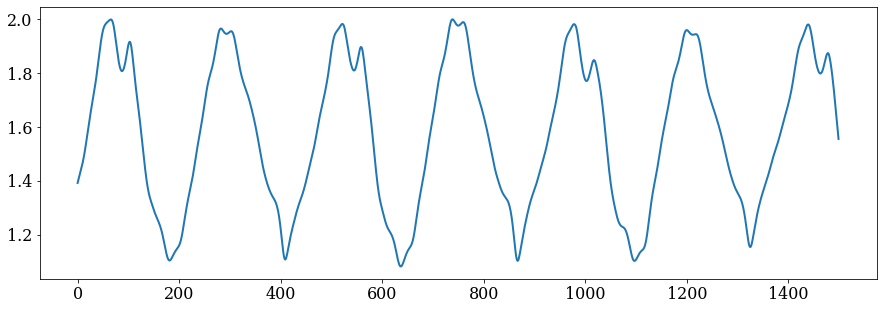

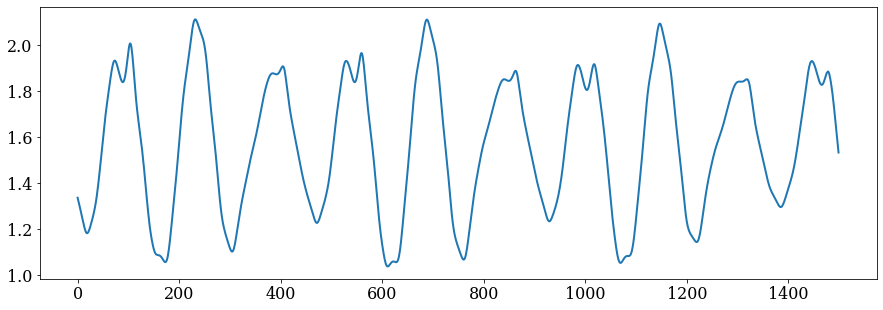

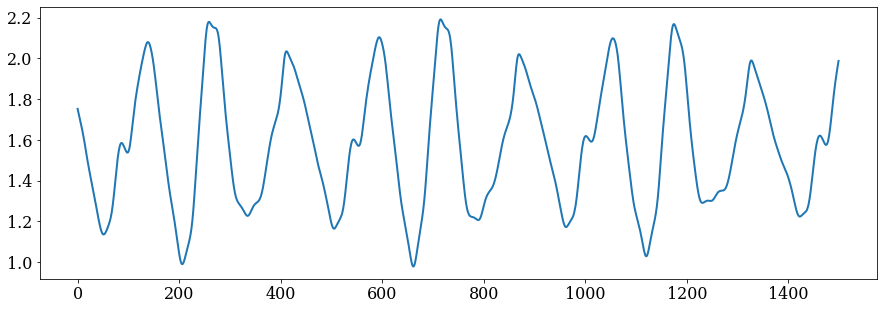

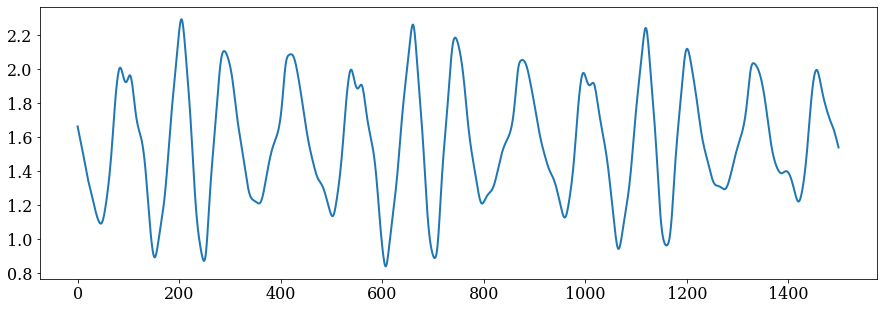

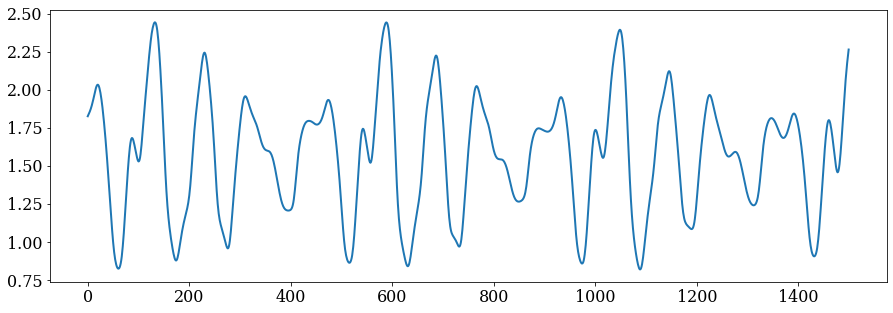

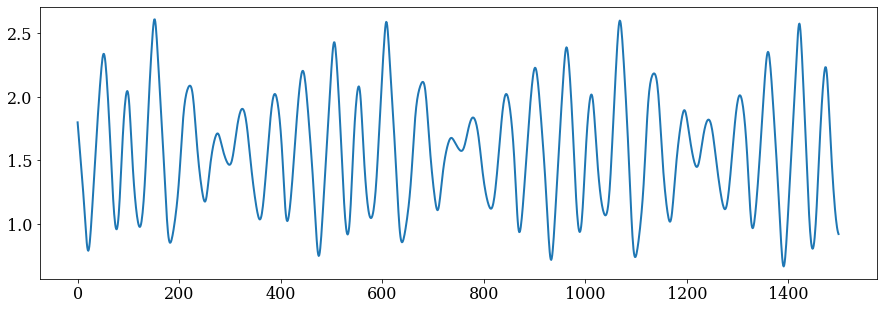

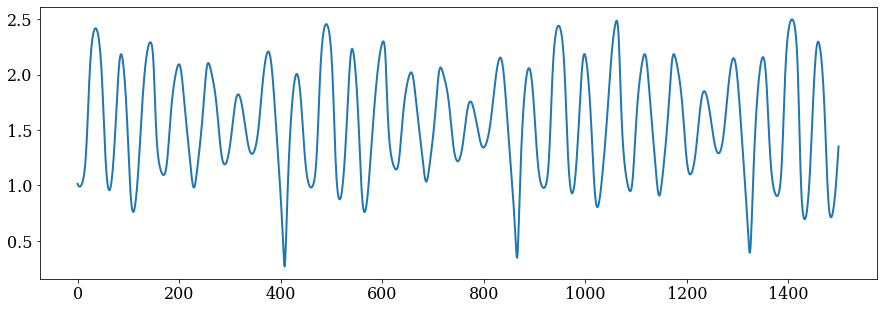

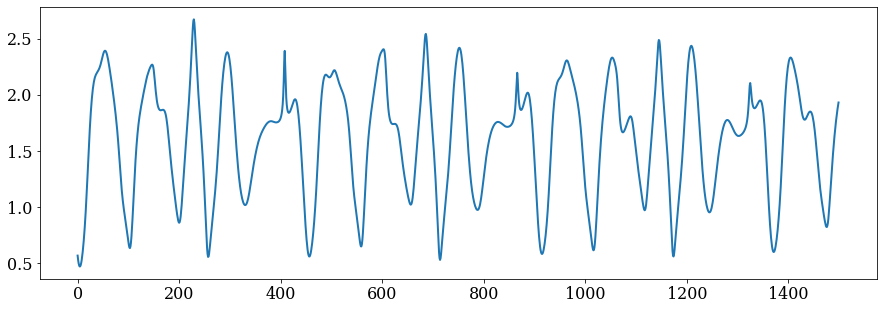

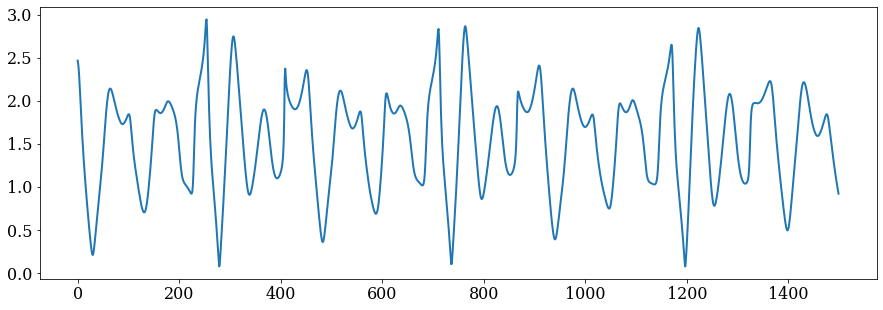

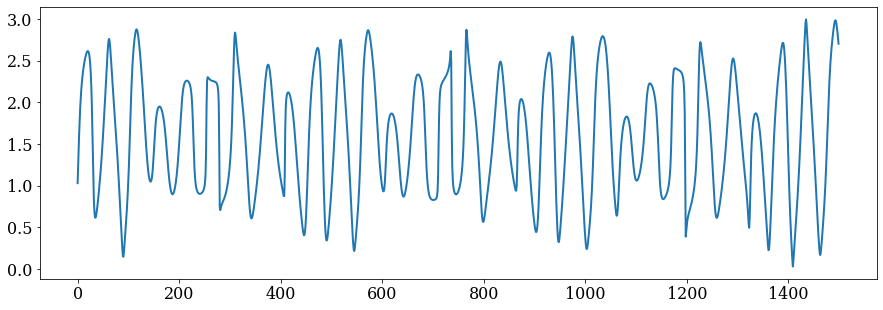

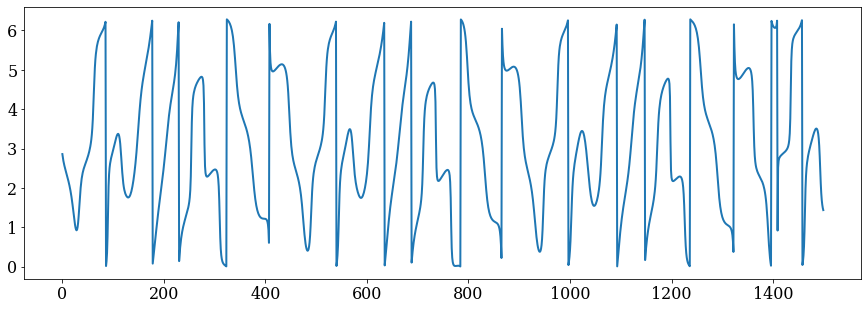

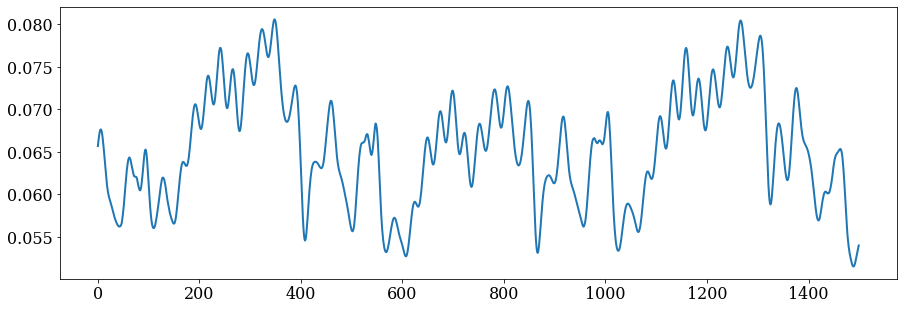

In [543]:
plt.figure(figsize=(15,5))
plt.plot(x_acc[499:2000])
plt.show()
for i in range(X_sp.shape[1]):
    plt.figure(figsize=(15,5))
    plt.plot(X_sp[:1500,i])
    plt.show()

In [534]:
pca_ = KernelPCA(n_components = 1,
                 kernel = 'linear',
                )
tmp = pca_.fit_transform(X_sp[:,:3])


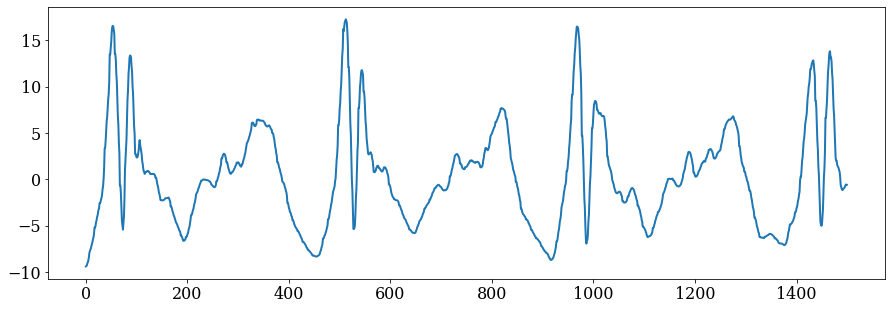

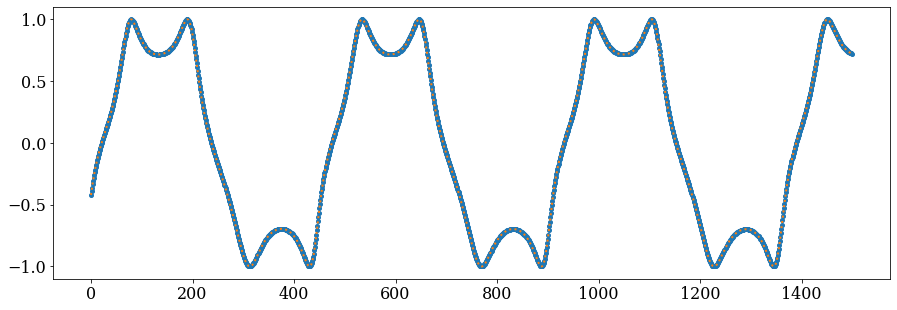

In [535]:
plt.figure(figsize=(15,5))
plt.plot(x_acc[500:2000])
plt.show()

plt.figure(figsize=(15,5))
tmp =np.cos( 2*np.pi*(tmp - tmp.min())/(tmp.max() - tmp.min()))
plt.plot(tmp[:1500],'.')
plt.plot(tmp[:1500],':')
plt.show()

In [448]:
import torch

In [414]:
from torch import nn, optim

In [463]:
class Autoencoder(nn.Module):
    def __init__(self, in_shape):
        super(Autoencoder, self).__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(in_shape, in_shape),
            nn.Sigmoid(),
            nn.Linear(in_shape, in_shape),
            nn.Sigmoid(),
            nn.Linear(in_shape, 1),
            nn.Sigmoid()
        )
        
        self.decode = nn.Sequential(
            nn.Linear(1, in_shape),
            nn.Sigmoid(),
            nn.Linear(in_shape, in_shape),
            nn.Sigmoid(),
            nn.Linear(in_shape, in_shape)
            
        )
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

def train(model, optimizer, n_epochs, x_real, val_part = 0.3):
  
    l = len(x_real)
    val_l = int(len(x_real) * val_part)
    
    model.train()
    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()
        z_encoded = model.encode(x_real)
        z_scale = (z_encoded - z_encoded.min()) / (z_encoded.max() - z_encoded.min())
        
        ###############################################################
        limit_1 = ((z_scale[:-1] - z_scale[1:]) >= 0)
        limit_2 = ((z_scale[:-1] - z_scale[1:]) <= 0.95)
        scale_loss = 0.1 * torch.sum( limit_1 * limit_2 )
        
        ###############################################################
        delata_z = limit_1 * (z_encoded[:-1] - z_encoded[1:])
        z_loss = torch.sum( torch.exp(- 200 * (delata_z - 0.45)**6) )
    
        ###############################################################
        x_reconstruct = model(x_real)
        reconstruction_loss = torch.mean( ( (x_reconstruct) - (x_real) )**2 )
    
        ###############################################################
        loss = reconstruction_loss + z_loss
        loss.backward()
        optimizer.step()
        
        ###############################################################
        if epoch % int(0.2*n_epochs) == 0:
            
            print(
                f'Epoch {epoch} \t' +
                f'Reconstruction loss: {reconstruction_loss.item():.4g} \t' +
                f'Z loss: {z_loss.item():.4g} \t' +
                f'Scale loss: {scale_loss.item():.4g}'
            )
            
            plt.figure(figsize=(15,5))
            plt.plot(z_scale[:1500].detach().numpy(),'.')
            plt.plot(z_scale[:1500].detach().numpy(),':')
            plt.show()

Epoch 4000 	Reconstruction loss: 1.516 	Z loss: 760 	Scale loss: 364.2


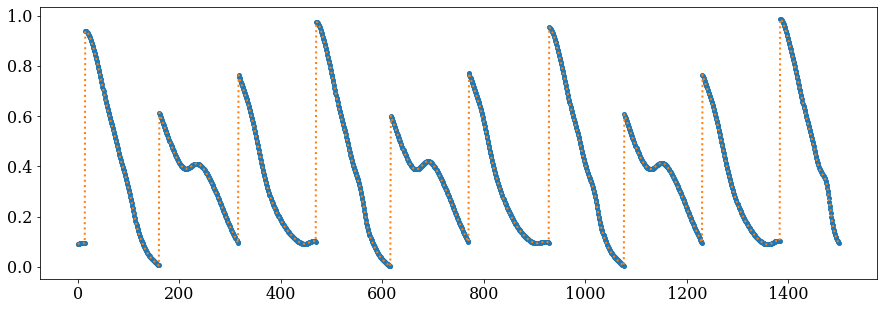

Epoch 8000 	Reconstruction loss: 1.516 	Z loss: 760 	Scale loss: 39.3


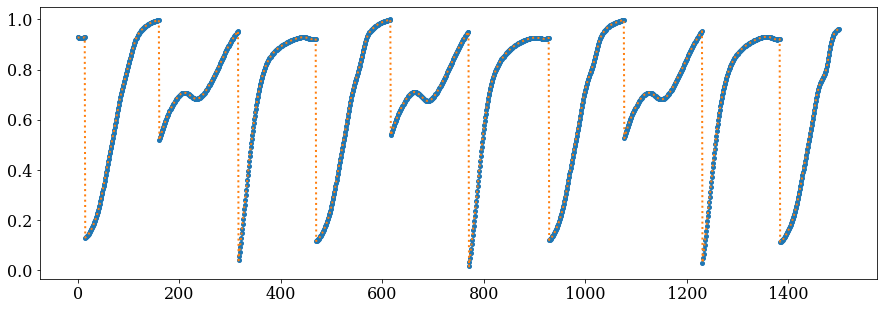

Epoch 12000 	Reconstruction loss: 1.516 	Z loss: 760 	Scale loss: 352.4


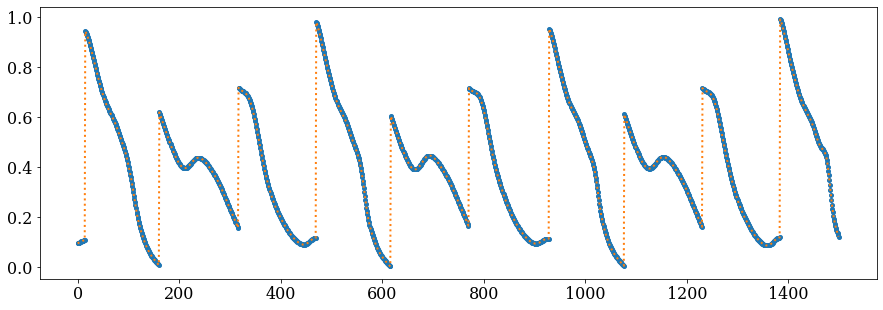

Epoch 16000 	Reconstruction loss: 1.516 	Z loss: 760 	Scale loss: 354.8


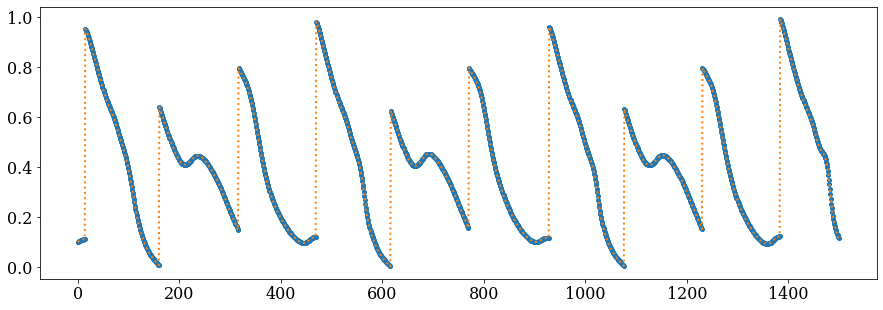

Epoch 20000 	Reconstruction loss: 1.516 	Z loss: 760 	Scale loss: 44.3


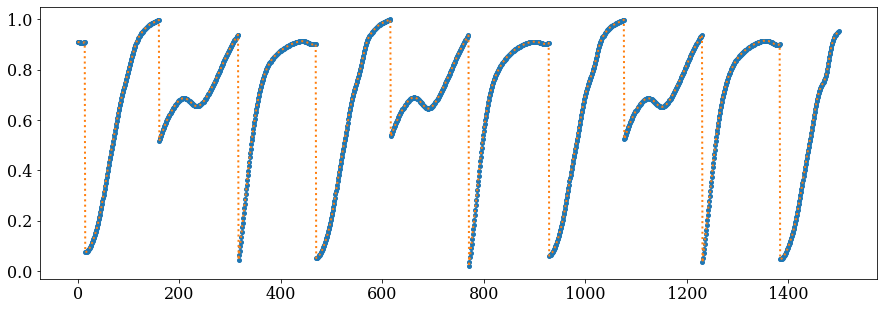

In [464]:
x = torch.from_numpy(X_sp[:,:3]).to('cpu')
encoder = Autoencoder(in_shape = 3).double().to('cpu')
optimizer = optim.Adam(encoder.parameters())

###############################################################
train(model = encoder,
      optimizer = optimizer,
      n_epochs = 20000,
      x_real = x)

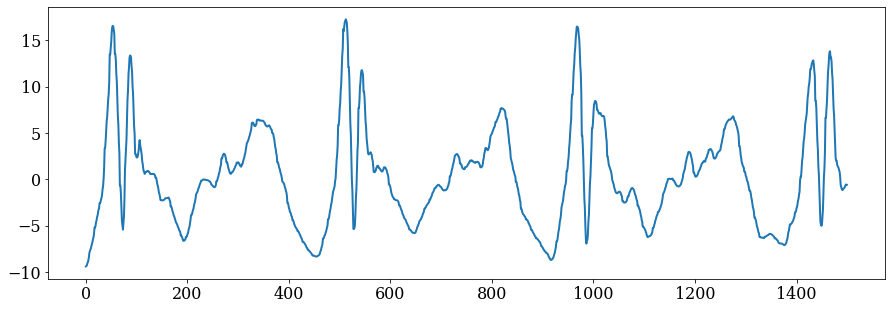

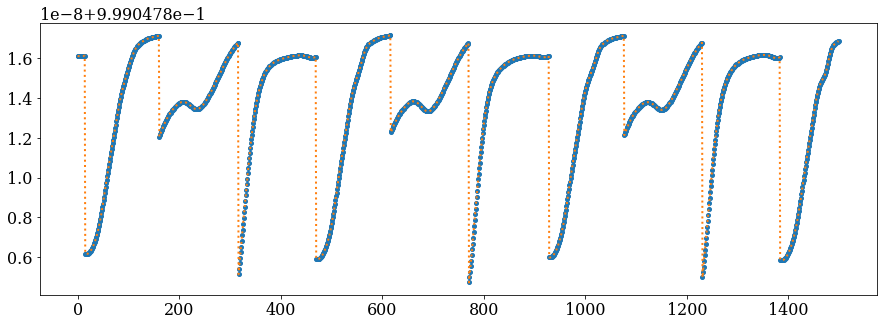

In [465]:
with torch.no_grad():
    encoded = encoder.encode(x)
    decoded = encoder.decode(encoded)
    enc = encoded.cpu().detach().numpy()
    dec = decoded.cpu().detach().numpy()
    
plt.figure(figsize=(15,5))
plt.plot(x_acc[500:2000])
plt.show()

plt.figure(figsize=(15,5))
plt.plot(enc[:1500],'.')
plt.plot(enc[:1500],':')
plt.show()

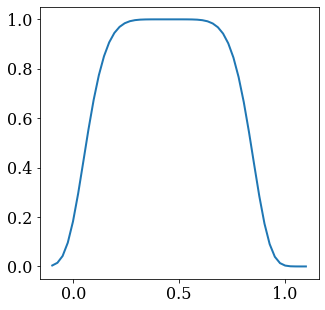

In [444]:
t = np.linspace(-0.1,1.1)
x = np.exp(- 200 * (t - 0.45)**6)
plt.plot(t, x)